<< 자전거 사고 통계 데이터를 수집합니다. >>
http://apis.data.go.kr/B552061/frequentzoneBicycle/getRestFrequentzoneBicycle?type=json&ServiceKey=FuNAEFilXRnDSE2p3GKp5niRVFe%2FD4%2BTDMR8iD%2BXNaknB%2FZhqh927sqfQnI9Py46kqpJem%2FeDJytFYmUT2uxyA%3D%3D&searchYearCd=2019&siDo=11&guGun=110&numOfRows=10&pageNo=1
[ 서울특별시 종로구 서린동(종로구청입구 부근) : 5건 ]
http://apis.data.go.kr/B552061/frequentzoneBicycle/getRestFrequentzoneBicycle?type=json&ServiceKey=FuNAEFilXRnDSE2p3GKp5niRVFe%2FD4%2BTDMR8iD%2BXNaknB%2FZhqh927sqfQnI9Py46kqpJem%2FeDJytFYmUT2uxyA%3D%3D&searchYearCd=2020&siDo=11&guGun=110&numOfRows=10&pageNo=1
[ 서울특별시 종로구 세종로(세종로180 부근) : 5건 ]
[ 서울특별시 종로구 창신동(흥인지문사거리 부근) : 3건 ]
http://apis.data.go.kr/B552061/frequentzoneBicycle/getRestFrequentzoneBicycle?type=json&ServiceKey=FuNAEFilXRnDSE2p3GKp5niRVFe%2FD4%2BTDMR8iD%2BXNaknB%2FZhqh927sqfQnI9Py46kqpJem%2FeDJytFYmUT2uxyA%3D%3D&searchYearCd=2021&siDo=11&guGun=110&numOfRows=10&pageNo=1
[ 서울특별시 종로구 적선동(적선현대빌딩 부근) : 5건 ]
[ 서울특별시 종로구 인의동(종로4가사거리 부근) : 4건 ]
[ 서울특별시 종로구 서린동(종로구청

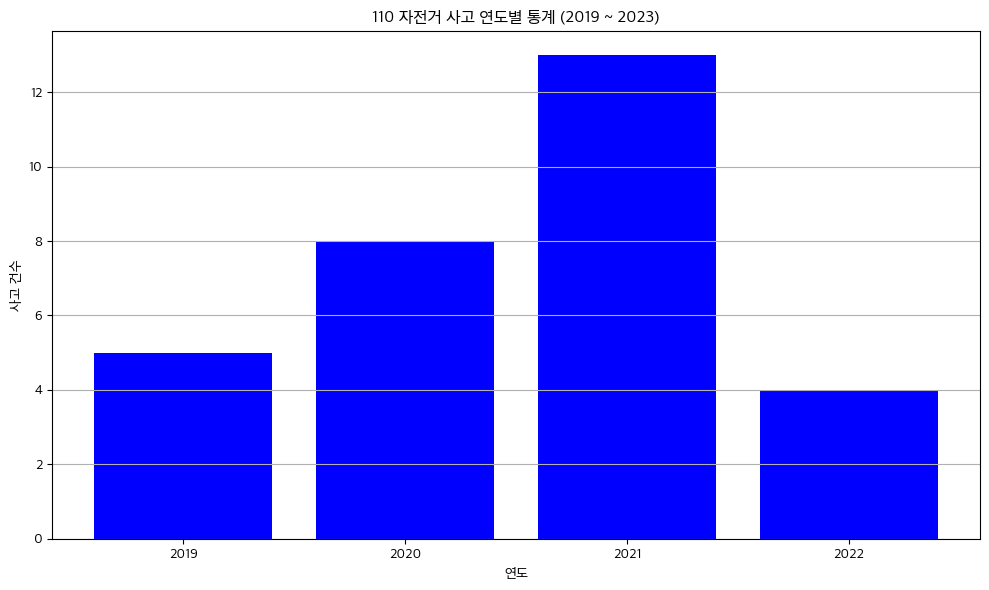

In [150]:
import urllib.request
import datetime
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt  # Matplotlib 추가
import matplotlib.font_manager as fm
from dotenv import load_dotenv
import os

load_dotenv()
ServiceKey = os.getenv('API_KEY')

#[CODE 1]
def getRequestUrl(url):
    req = urllib.request.Request(url)
    try:
        response = urllib.request.urlopen(req)
        if response.getcode() == 200:
            print("[%s] Url Request Success" % datetime.datetime.now())
            return response.read().decode('utf-8')
    except Exception as e:
        print(e)
        print("[%s] Error for URL : %s" % (datetime.datetime.now(), url))
        return None

def getBicycleAccidentStatsItem(year, sido_code, gugun):
    """지정된 시도 및 구군의 자전거 사고 통계를 가져오는 함수"""
    service_url = "http://apis.data.go.kr/B552061/frequentzoneBicycle/getRestFrequentzoneBicycle"
    parameters = f"?type=json&ServiceKey={ServiceKey}&searchYearCd={year}&siDo={sido_code}&guGun={gugun}&numOfRows=10&pageNo=1"
    url = service_url + parameters
    print(url)  # 요청 URL 확인
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print("데이터 요청 실패:", response.status_code)
        return None

def getBicycleAccidentStatsService(sido_code, gugun, start_year, end_year):
    jsonResult = []
    result = []
    isDataEnd = False  # 데이터 끝 확인용 플래그 초기화

    for year in range(start_year, end_year + 1):
        if isDataEnd:
            break  # 데이터 끝이면 작업 중지

        jsonData = getBicycleAccidentStatsItem(year, sido_code, gugun)

        if jsonData and jsonData['resultCode'] == '00':
            items = jsonData['items'].get('item', [])
            if not items:
                print(f"{year}년 데이터 없음.")
                isDataEnd = True
                break  # 더 이상 데이터가 없으므로 종료

            for item in items:
                accident_count = item.get('occrrnc_cnt', 0)  # 사고 건수
                spot_name = item.get('spot_nm', 'Unknown')  # 사고 발생 지역명
                print(f"[ {spot_name} : {accident_count}건 ]")
                jsonResult.append({'spot_name': spot_name, 'year': year, 'accident_count': accident_count})
                result.append([spot_name, year, accident_count])

        else:
            print("데이터를 불러올 수 없습니다.")
            isDataEnd = True  # 에러 발생 시 데이터 끝으로 설정

    return jsonResult, result

def main():
    print("<< 자전거 사고 통계 데이터를 수집합니다. >>")
    sido_code = input('시도 코드를 입력해주세요 : ')
    gugun = input('구군를 입력해주세요 : ')
    start_year = int(input('데이터를 몇 년부터 수집할까요? : '))
    end_year = int(input('데이터를 몇 년까지 수집할까요? : '))

    jsonResult, result = getBicycleAccidentStatsService(sido_code, gugun, start_year, end_year)

    if not jsonResult:
        print('데이터가 전달되지 않았습니다. 공공데이터포털의 서비스 상태를 확인하기 바랍니다.')
    else:
        # 파일 저장 1 : json 파일
        with open('./bicycle_accidents.json', 'w', encoding='utf8') as outfile:
            jsonFile = json.dumps(jsonResult, indent=4, ensure_ascii=False)
            outfile.write(jsonFile)

        # 파일 저장 2 : csv 파일
        columns = ["사고 발생 지역", "연도", "사고 건수"]
        result_df = pd.DataFrame(result, columns=columns)
        result_df.to_csv('./bicycle_accidents.csv', index=False, encoding='utf-8')

        # 시각화 코드 추가
        # 연도별 사고 건수 집계
        yearly_accident_counts = result_df.groupby('연도')['사고 건수'].sum().reset_index()

        font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
        font_prop = fm.FontProperties(fname=font_path)

        # Matplotlib 기본 폰트 설정
        plt.rc('font', family=font_prop.get_name())

        # 음수 기호 깨짐 방지
        plt.rcParams['axes.unicode_minus'] = False


        # 시각화
        plt.figure(figsize=(10, 6))
        plt.bar(yearly_accident_counts['연도'], yearly_accident_counts['사고 건수'], color='blue')
        plt.title(f"{gugun} 자전거 사고 연도별 통계 ({start_year} ~ {end_year})")
        plt.xlabel("연도")
        plt.ylabel("사고 건수")
        plt.xticks(yearly_accident_counts['연도'])
        plt.grid(axis='y')
        plt.tight_layout()
        plt.savefig(f'./bicycle_accidents_{sido_code}_{gugun}.png')  # 그래프 저장
        plt.show()  # 그래프 표시

if __name__ == '__main__':
    main()